# Analysing Vaccination Strategies in the Detailed Model

- Using the 11 age groups from TABNET, calculated rates and everything
- We will analyse strategies for cities with different values of $\beta$ and, therefore, with different patterns of susceptibility 
- First, we will analyse different strategies with the same vaccination rate for both cities over different years
- Then, we will use different vaccination rates for different strategies and do a heatplot of reduction of cases overall

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
np.random.seed(123)

In [2]:
@np.vectorize
def beta_step(beta_0,beta_aug,t_start,t_season,t_year,t):
  # beta_0 is the basal beta
  # beta_aug is the beta at high transmission season
  # t_start is start time of the high transmission season
  # t_season is the duration of the high transmission season
  # t_year is the duration of a year (giving the function periodicity)
  # t is current time time
  # normalize time up to a year
  t_norm = t%t_year
  # and now we look for the value of the function
  if(t_norm >= t_start and t_norm <= t_start + t_season):
    value = beta_aug
  else:
    value = beta_0
  return value

In [3]:
def calculate_l_vector(alpha,l1):
    list_l = [] # creando uma lista l l1, l2, l3, .....
    elements_l = alpha.shape[0]
    for i in range(elements_l):
        # if it is the first element
        if(i == 0):
            list_l.append(l1)
        elif(i == elements_l-1): # if it is the last element (mortality term)
            list_l.append(list_l[-1]*alpha[-2]/alpha[-1])
        else: # in other case (intermediate elements)
            list_l.append(list_l[-1]*alpha[i-1]/alpha[i])
    return list_l

In [13]:
def n_groups_seasonal_model_vaccine(y, t, N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec):
    # N is number of age groups 
    S = y[0:N]
    I = y[N:2*N]
    R = y[2*N:3*N]
    C = y[3*N:4*N]
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    IT = sum(I) #total infected
    S = np.append(S,0)
    I = np.append(I,0)
    R = np.append(R,0)
    S = np.append(0,S)
    I = np.append(0,I)
    R = np.append(0,R)
    C = np.append(C,0)
    C = np.append(0,C)
    l_vec_2 = np.append(0,l_vec)
    l_vec_2 = l_vec_2[:-1]
    dSdt = -beta*S[1:-1]*IT - mu_vec*S[1:-1] - l_vec*S[1:-1] + l_vec_2*S[:-2]
    dIdt =  beta*S[1:-1]*IT - gamma*I[1:-1] - mu_vec*I[1:-1] - l_vec*I[1:-1] + l_vec_2*I[:-2]
    dRdt =  gamma*I[1:-1] - mu_vec*R[1:-1] - l_vec*R[1:-1] + l_vec_2*R[:-2]
    dSdt[0] = dSdt[0] + nu
    dCdt = beta*S[1:-1]*IT
    return np.array([dSdt, dIdt, dRdt,dCdt]).flatten()

In [14]:
def modify_initial_condition(y):
    y_aux = y.copy()
    y_tmp = y.copy()
    y_tmp[:N] = (y_aux[:N]*pop - 1)/pop # suscteptible reduction
    y_tmp[N:2*N] = (y_aux[N:2*N]*pop + 1)/pop # infected grow
    y_tmp[3*N:4*N] = (y_aux[3*N:4*N]*pop + 1)/pop  # increase in new cases per day
    return y_tmp

In [15]:
def define_initial_condition():
    y0 = np.array([alpha1,alpha2,alpha3,alpha4,(alpha5*pop-1)/pop,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,
            0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       0,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0])
    return y0

In [16]:
# number of age groups
N = 11

# number of people per age group
alpha1 = 793061 # 0 to 4 
alpha2 = 803773 # 5 to 9
alpha3 = 836496 # 10 to 14
alpha4 = 877970 # 15 to 19
alpha5 = 1960304 # 20 to 29
alpha6 = 1995084 # 30 to 39
alpha7 = 1666076 # 40 to 49
alpha8 = 1319655 # 50 to 59
alpha9 = 878162 # 60 to 59
alpha10 = 476538 # 70 to 79 
alpha11 = 245667 # 80+

# creating vector of alphas
alpha_pop = np.array([alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, 
                  alpha7, alpha8, alpha9, alpha10, alpha11])

# total population 
pop = alpha_pop.sum()

# dividing by total population
alpha1 = alpha1/pop
alpha2 = alpha2/pop
alpha3 = alpha3/pop
alpha4 = alpha4/pop
alpha5 = alpha5/pop
alpha6 = alpha6/pop
alpha7 = alpha7/pop
alpha8 = alpha8/pop
alpha9 = alpha9/pop
alpha10 = alpha10/pop
alpha11 = alpha11/pop

# creating a new vector of alphas (divided by overall population, as proportions)
alpha = np.array([alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, 
                  alpha7, alpha8, alpha9, alpha10, alpha11])


# demographical constants for the model
l1 = 1/(365*5) # how long does the first age group last (in days)?
nu = l1*alpha[0] # calculating the corresponding birth rate
l_vec = calculate_l_vector(alpha, l1) # calculating l aging elements + coupled death rate
mu_vec = np.array([0,0,0,0,0,0,0,0,0,0, l_vec[-1]]) # death rates array
# calculating aging rates vector
l_vec = l_vec[:-1] 
l_vec.append(0)
l_vec = np.array(l_vec)


# disease parameters
gamma = 1/(7.0)
beta_0 = 0.0*gamma

# year parameters for disease seasonality
t_year = 365
t_start = 0
t_season = 60

# a characteristic season
t_season_single = np.arange(0,365,1)

# number of seasons to simulate
seasons = 40

In [17]:
# defining the beta values
beta_1 = 2.0*gamma
beta_2 = 5.0*gamma

## Part 1: Different vaccination strategies for different values of $\beta$

- Sort of a proof of concept for two different beta values
- Calculating the number of cases as a function of time, for a fixed value of vaccination rate $r$ as well

### SP Pattern

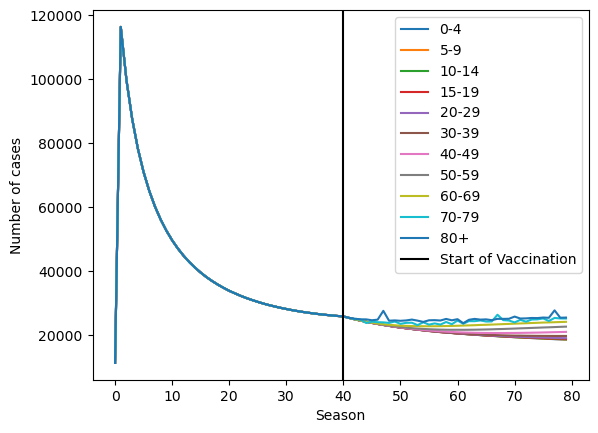

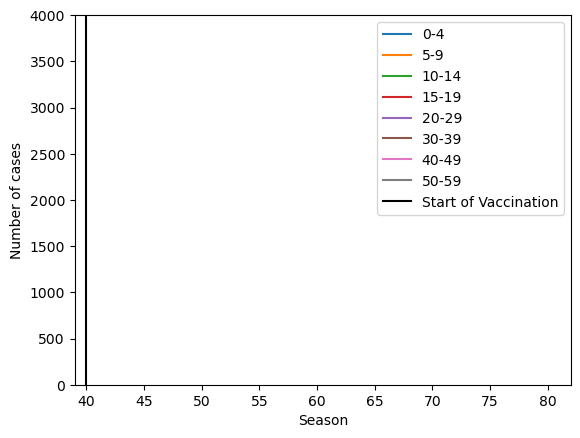

In [25]:
beta_aug = beta_1
inf_str = []

for i in range(N):
    inf_ano = []

    # before intervention
    #print('before intervention')
    r0_vec = np.zeros(N)
    y0 = define_initial_condition()
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, np.zeros(N)))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    #plt.show()


    # after intervention
    #print('after intervention')
    r0_vec = np.zeros(11)
    r0_vec[i] = (10000)
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r0_vec))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        y0[:N] = (y0[:N]*pop - r0_vec)/pop
        y0[2*N:3*N] = (y0[2*N:3*N]*pop + r0_vec)/pop
        inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    #plt.show()
    
    inf_str.append(inf_ano)
    
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(N):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylabel('Number of cases')
plt.xlabel('Season')
plt.show()

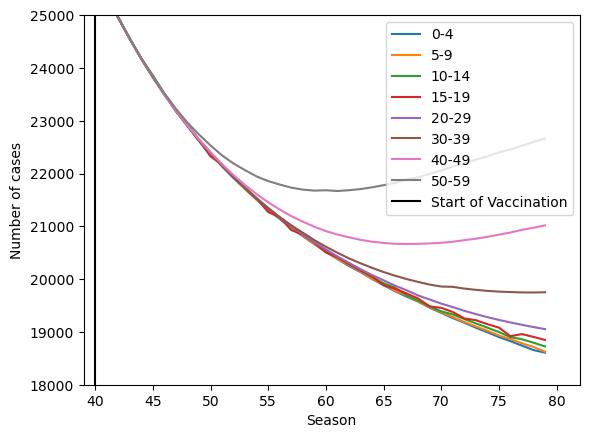

In [30]:
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(8):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylabel('Number of cases')
plt.xlabel('Season')
plt.xlim((39,82))
plt.ylim((18000,25000))
plt.show()

### RJ Pattern

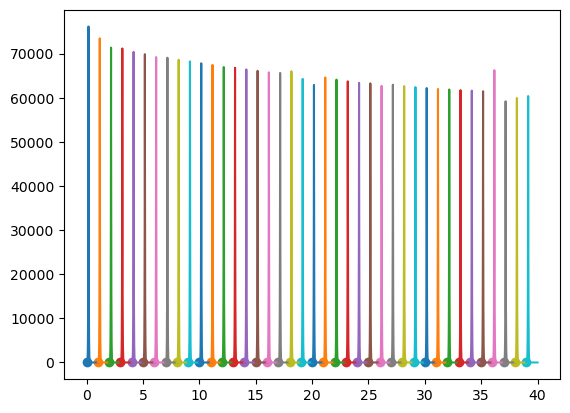

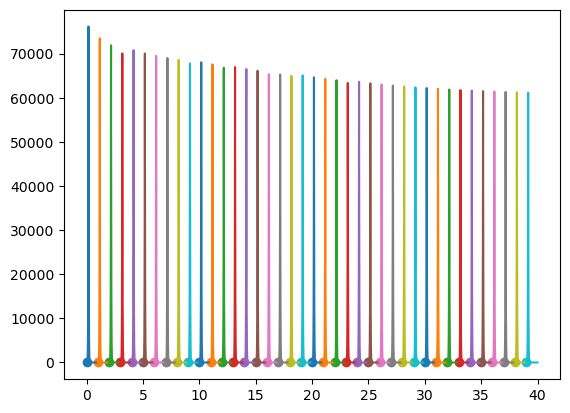

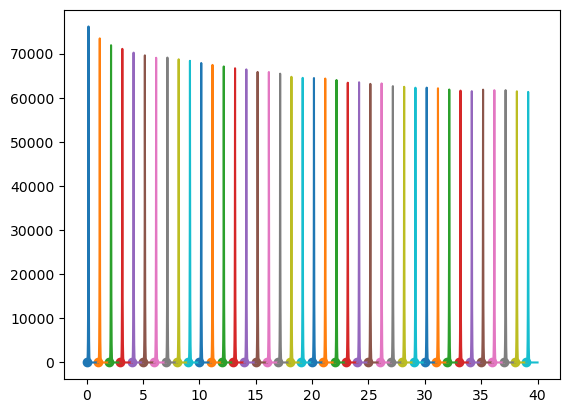

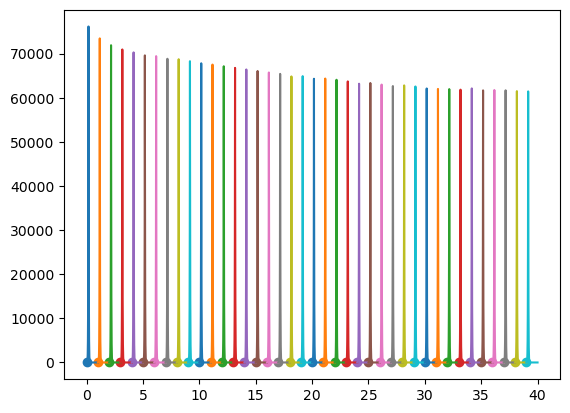

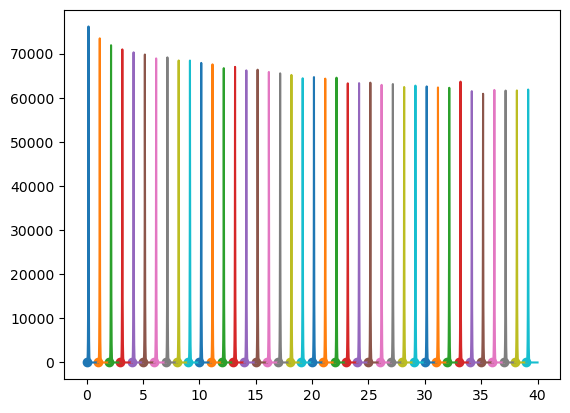

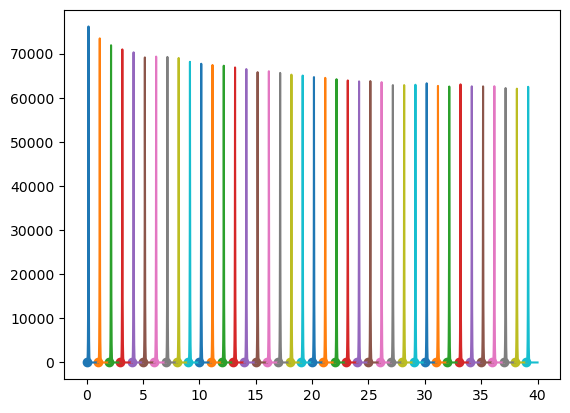

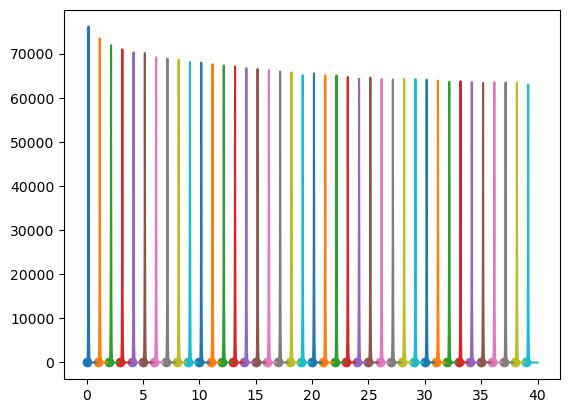

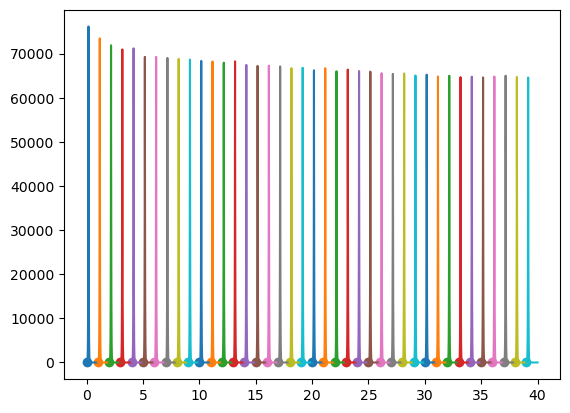

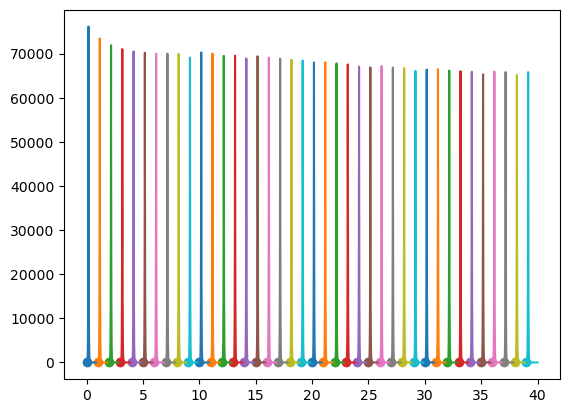

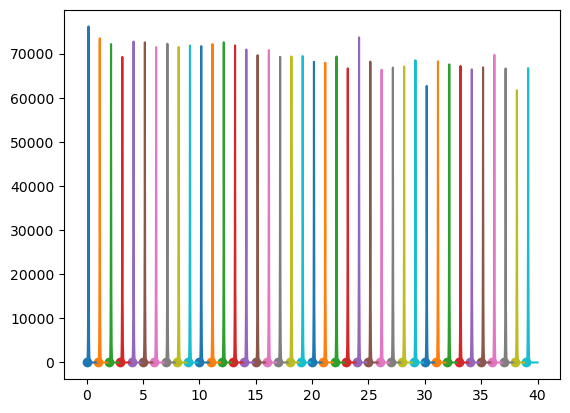

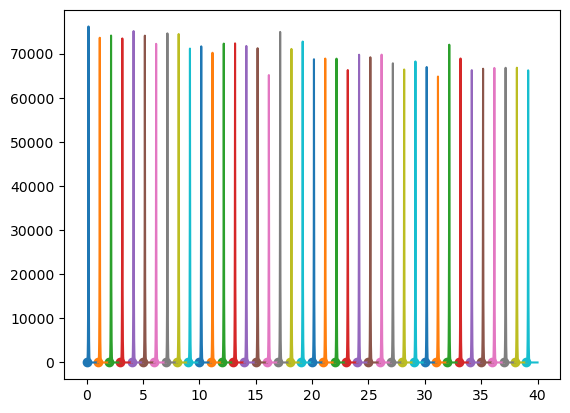

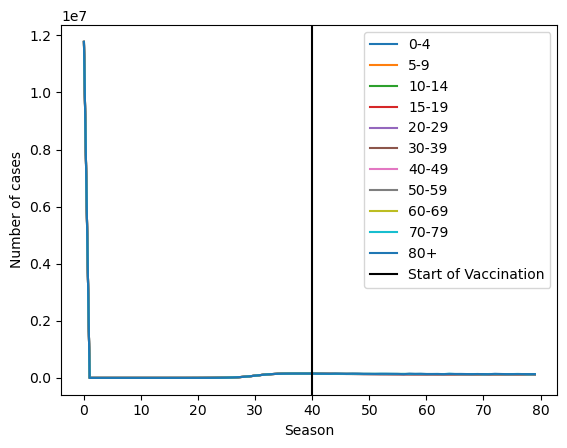

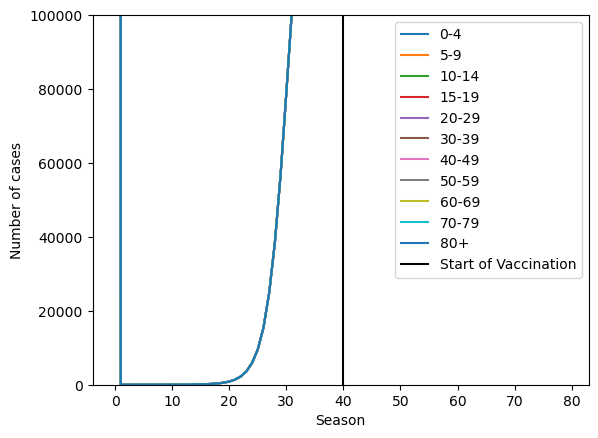

In [35]:
beta_aug = beta_2
inf_str = []

for i in range(N):
    inf_ano = []

    # before intervention
    #print('before intervention')
    r0_vec = np.zeros(11)
    y0 = define_initial_condition()
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, np.zeros(N)))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    #plt.show()


    # after intervention
    #print('after intervention')
    r0_vec = np.zeros(11)
    r0_vec[i] = 10000
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r0_vec))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        y0[:N] = (y0[:N]*pop - r0_vec)/pop
        y0[2*N:3*N] = (y0[2*N:3*N]*pop + r0_vec)/pop
        inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    plt.show()
    
    inf_str.append(inf_ano)
    
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(N):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylabel('Number of cases')
plt.xlabel('Season')
plt.show()

faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(11):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylabel('Number of cases')
plt.xlabel('Season')
plt.ylim((0,100000))
plt.show()

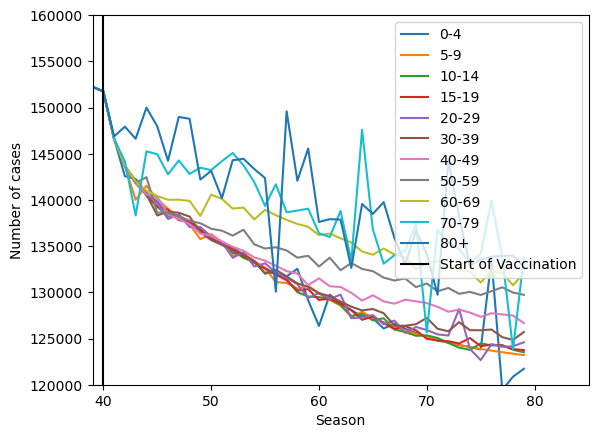

In [34]:
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(11):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylabel('Number of cases')
plt.xlabel('Season')
plt.ylim((120000,160000))
plt.xlim((39,85))
plt.show()

## Part 2: Analysing vaccination rate - strategy as raw numbers accumulated later

### SP Pattern

In [17]:
beta_aug = beta_1
inf_str = []
vacc_rates = np.arange(0,1,0.1)

for vacc_rate in vacc_rates:
    inf_rates = []
    for i in range(N):
        inf_ano = []
        # before intervention
        #print('before intervention')
        r0_vec = np.zeros(11)
        y0 = define_initial_condition()
        for season in np.arange(seasons):
            ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, np.zeros(N)))
            y0 = ret[-1,:].copy()
            y0 = modify_initial_condition(y0)
            inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
            #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
            #plt.scatter((season*365)/365,y0[N:2*N].sum())
            #if(season == 0):
                #plt.show()
        #plt.legend()
        #plt.show()


        # after intervention
        #print('after intervention')
        r0_vec = np.zeros(11)
        r0_vec[i] = vacc_rate
        for season in np.arange(seasons):
            ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r0_vec))
            y0 = ret[-1,:].copy()
            y0 = modify_initial_condition(y0)
            inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
            inf_ano.append(inf_total)
            #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
            #plt.scatter((season*365)/365,y0[N:2*N].sum())
            #if(season == 0):
                #plt.show()
        #plt.legend()
        #plt.show()

        inf_rates.append(np.sum(inf_ano))
    inf_str.append(inf_rates)

In [18]:
inf_str_bk = inf_str

In [20]:
inf_str = inf_str_bk

In [21]:
inf_str = np.array(inf_str)

In [22]:
inf_str = abs(inf_str-1016899.8921312747)/(1016899.8921312747)

In [23]:
inf_str = inf_str[1:,:]

In [24]:
inf_str

array([[0.94369682, 0.94288585, 0.94359338, 0.94439641, 0.98100787,
        0.97904607, 0.963358  , 0.91389   , 0.7415566 , 0.43517289,
        0.16439146],
       [0.94492473, 0.94435769, 0.94505492, 0.94593617, 0.98181111,
        0.97987042, 0.9645752 , 0.91544751, 0.74409173, 0.43870075,
        0.17698876],
       [0.94533628, 0.94492377, 0.94556889, 0.9464156 , 0.98207566,
        0.98014116, 0.96484003, 0.91585919, 0.74587394, 0.44225211,
        0.17886393],
       [0.94555024, 0.94516557, 0.9458042 , 0.94662146, 0.98219825,
        0.98026017, 0.9650896 , 0.91623033, 0.74577619, 0.44193554,
        0.1799567 ],
       [0.94574291, 0.94534641, 0.94598526, 0.94679743, 0.9822511 ,
        0.98029467, 0.96510811, 0.91608248, 0.74705095, 0.44319944,
        0.17931182],
       [0.94578135, 0.94535073, 0.94602827, 0.94683247, 0.98227111,
        0.98037474, 0.96516751, 0.91636902, 0.74712405, 0.4441694 ,
        0.1811445 ],
       [0.94580568, 0.94538231, 0.94608881, 0.94689819, 0.

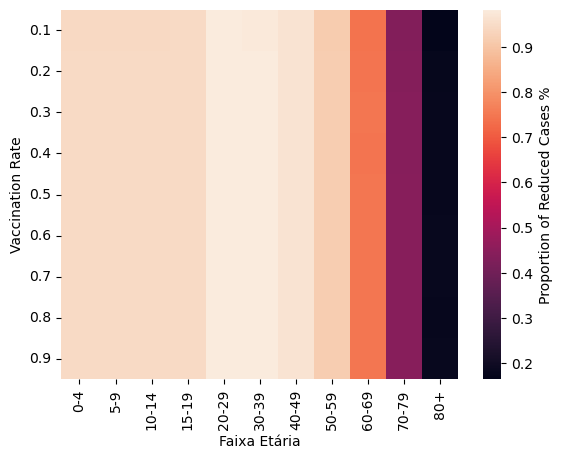

In [35]:
inf_str = np.array(inf_str)

ax = sns.heatmap(inf_str)

faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
ax.collections[0].colorbar.set_label("Proportion of Reduced Cases %")
ax.set(xticklabels = faixas_etarias, 
       yticklabels = np.round(np.arange(0,1,0.1)[1:],2),
      xlabel='Faixa Etária',
      ylabel="Vaccination Rate") 
plt.xticks(rotation = 'vertical')
plt.yticks(rotation = 'horizontal')
plt.show()


### RJ Pattern